# Map2D_B
---

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

import os
from scipy.constants import physical_constants

MC2 = physical_constants['electron mass energy equivalent in MeV'][0]*1e6
c = physical_constants['speed of light in vacuum'][0]

In [2]:
from gpt.maps import Map2D_B
from gpt import GPT

sol = Map2D_B('sol', 'fields/solenoid_SLA_L60.gdf')
?sol

Type:        Map2D_B
String form:
Name: sol
Type: Map2D_B
s-entrance: 0 m.
s-exit: 0.6 m.
Length: 0.6
Width: 0.4 m.
File:        ~/GitHub/lume-gpt/src/gpt/maps.py
Docstring:   Defines a 2D (r,z), (Br, Bz) cylindrically magnetic symmetric field map object

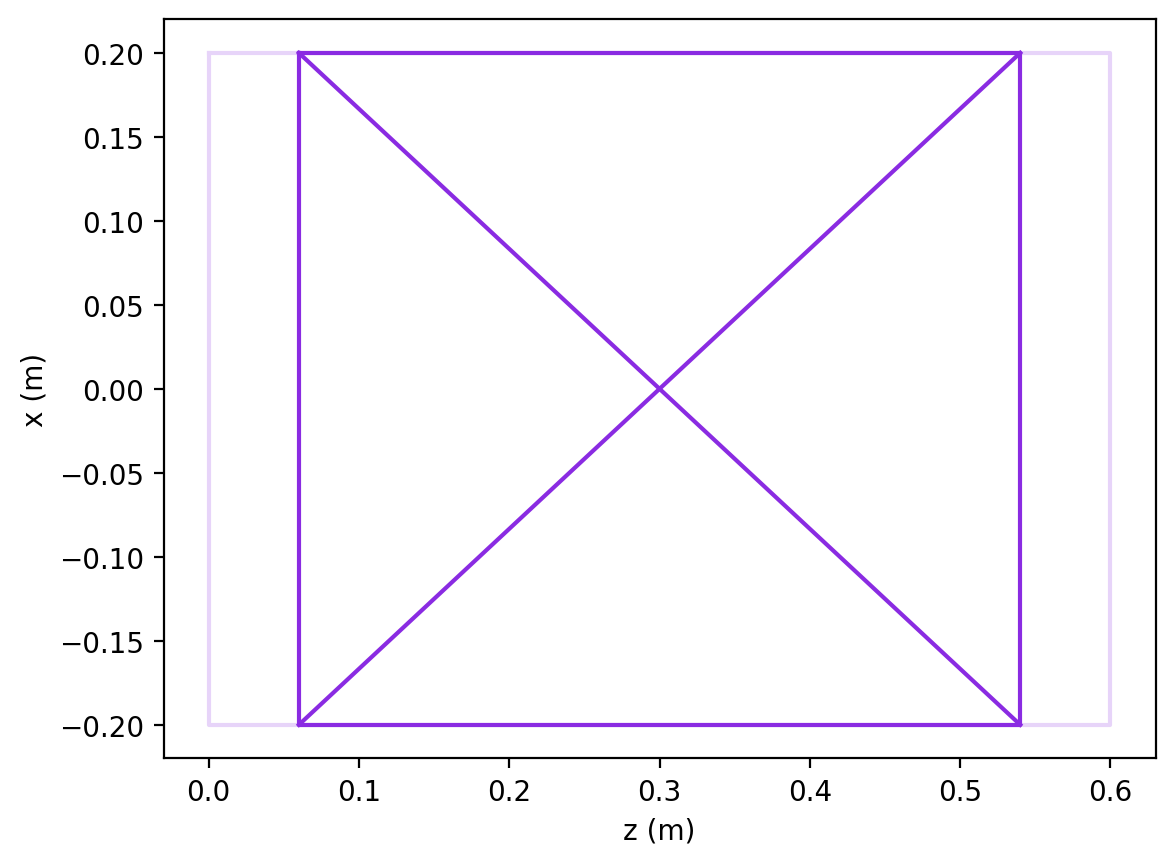

Signature:
sol.plot_floor(
    axis=None,
    alpha=1.0,
    ax=None,
    xlim=None,
    ylim=None,
    style='tao',
)
Docstring:
Function for plotting the relevant field/object region for cylindrically symmetric map object
Inputs: 
    axis: None or str('equal') to set axes to same scale
    alpha: alpha parameter to matplotlib pyplot.plot
    ax: matplotlib axis object, if None provided usess gca().
Outputs:
    ax: returns current axis handle being used
File:      ~/GitHub/lume-gpt/src/gpt/maps.py
Type:      method

In [3]:
?sol.plot_floor
sol.plot_floor();

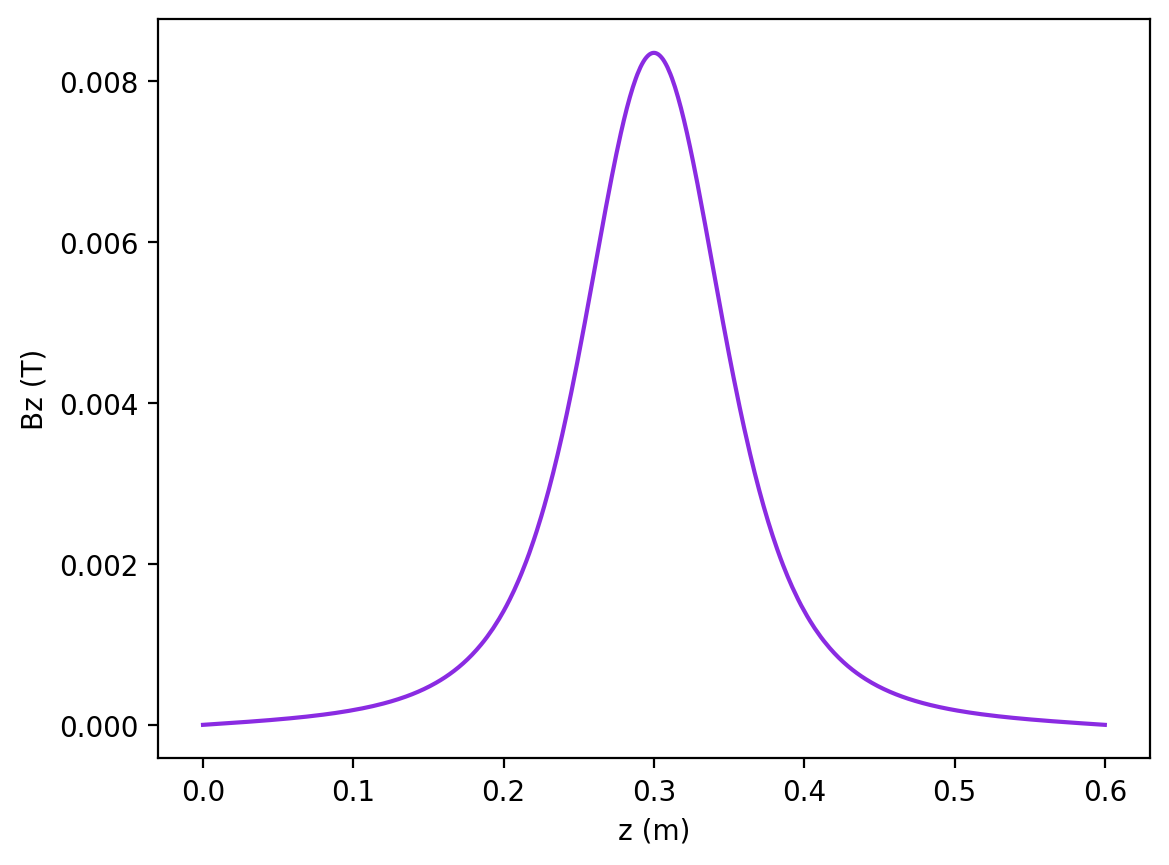

Signature: sol.plot_field_profile(ax=None, normalize=False)
Docstring:
Function for plotting the Ez or Bz on axis profile for cylindrically symmetric field map
Inputs: 
    element (object, Map2D_* )
    ax: matplotlib axis object, if None provided usess gca().
    normalize: boolean, normalize field to 1 or not
Outputs:
    ax: returns current axis handle being used
File:      ~/GitHub/lume-gpt/src/gpt/maps.py
Type:      method

In [4]:
?sol.plot_field_profile
sol.plot_field_profile();

In [5]:
?sol.field_integral
sol.field_integral

np.float64(0.0010917178030000001)

Type:        property
String form: <property object at 0x137418770>
Docstring:  
Computs the on axis field integral through a cylindrically symmetric field map 
Outputs:
    float, integral ( Fz(r=0) dz)

In [6]:
?sol.larmor_angle
print('Larmor Angle:', sol.larmor_angle(p=1e6)*180/np.pi,' deg.')

Larmor Angle: -9.376132418274313  deg.


Signature: sol.larmor_angle(p)
Docstring:
Computs the Larmor angle through a solenoid field map 
Inputs: 
    p: float, momentum in [eV/c]
Outputs:
    float, larmor angle in [rad]
File:      ~/GitHub/lume-gpt/src/gpt/maps.py
Type:      method

In [7]:
np.trapezoid(sol.Bz0, sol.z0) / np.max(sol.Bz0)

np.float64(0.1307289908992935)

# With Lattice Generation

In [8]:
from gpt.lattice import Lattice

In [9]:
lat = Lattice('Map1D_B')
lat.add(Map2D_B('sol', 'fields/solenoid_SLA_L60.gdf', scale=0.01), ds = 0.5, element_origin='center')  

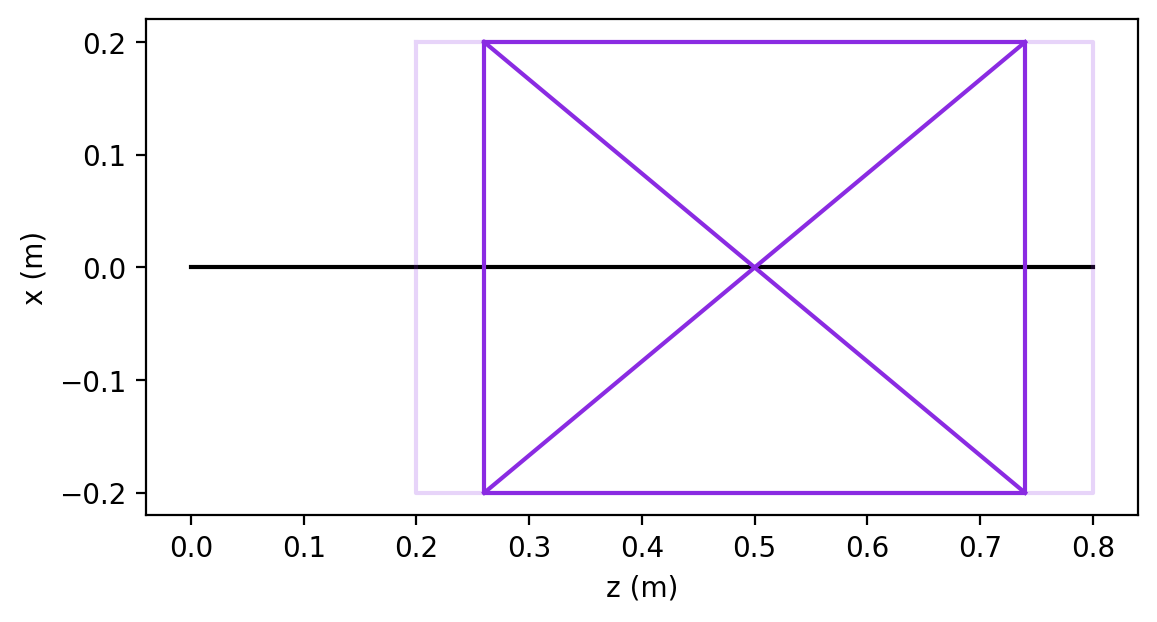

In [10]:
lat.plot_floor()
lat.write_gpt_lines(output_file='gpt.temp.in');

In [11]:
from distgen import Generator

E = 1e6
pz = np.sqrt(E**2 - MC2**2)

DISTGEN_YAML=f"""
n_particle: 1000
random_type: hammersley
species: electron

total_charge:
  units: nC
  value: 1
start:
  type: time
r_dist:
  sigma_xy:
    units: mm
    value: 1
  alpha:
    units: dimensionless
    value: 0.0
  type: rsg
transforms:
  avgpz:
    type: set_avg pz
    avg_pz: {pz} eV/c
"""

In [12]:
D = Generator(DISTGEN_YAML)
P = D.run()

In [13]:
G = GPT('gpt.temp.in', initial_particles=P)
G.set_variables({'ZSTOP': 1, 'Ntout': 500, 'sol_scale': 2})
G.run()

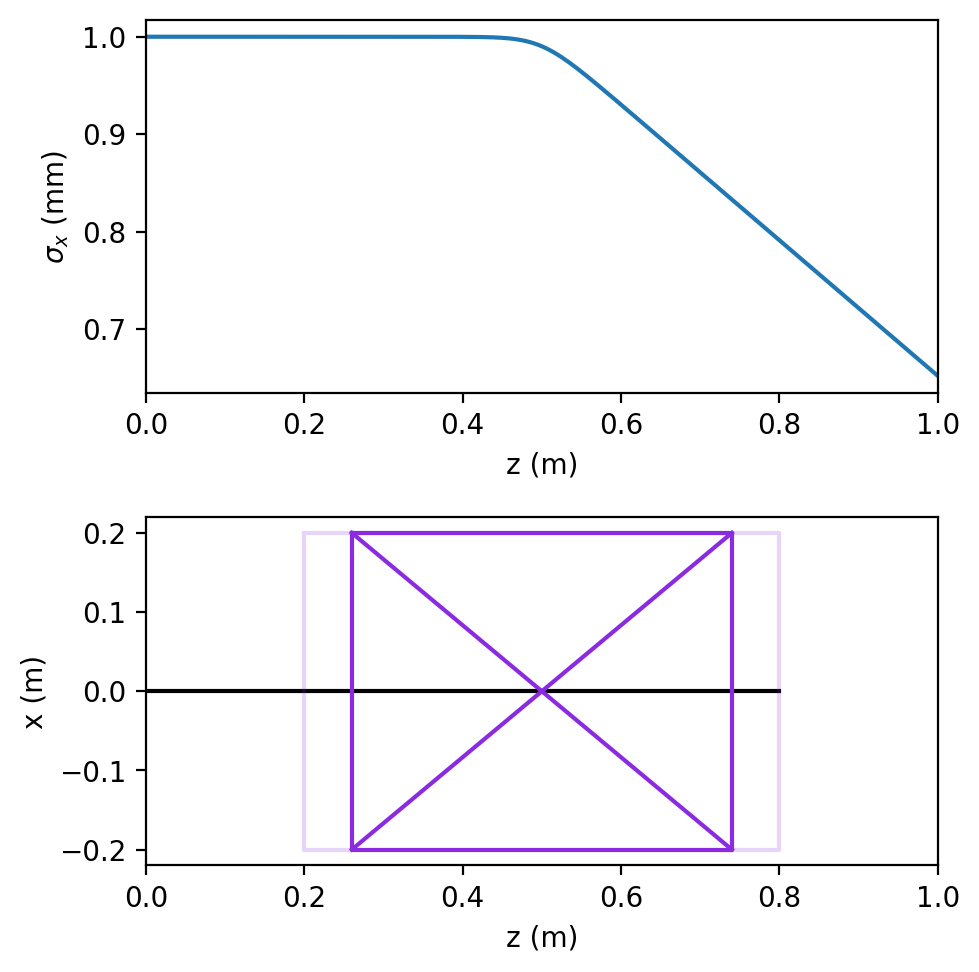

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5))

axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('sigma_x')*1e3)
axs[0].set_xlabel('z (m)')
axs[0].set_ylabel(r'$\sigma_x$ (mm)')

G.lattice.plot_floor(ax = axs[1])

axs[0].set_xlim([0, 1])
axs[1].set_xlim([0, 1])

plt.tight_layout()


In [15]:
def check_parsing():
    
    lat1 = Lattice('Map1D_B')
    lat1.add(Map2D_B('sol1', 'fields/solenoid_SLA_L60.gdf', scale=0.01), ds = 0.5, element_origin='center')  
    lat1.write_gpt_lines(output_file='parse_test.temp.in');

    G = GPT('parse_test.temp.in')
    lat2 = G.lattice

    os.remove('parse_test.temp.in')
    
    # Basic info
    assert lat1['sol1']._length==lat2['sol1']._length
    assert lat1['sol1']._width==lat2['sol1']._width
    assert lat1['sol1']._height==lat2['sol1']._height
    # assert lat1['sol1']._ecs==lat2['sol1']._ecs # FIX LATER
    assert lat1['sol1'].name == lat2['sol1'].name
    
check_parsing()


In [16]:
if os.path.exists('gpt.temp.in'):
    os.remove('gpt.temp.in')

In [17]:
0.008 * 6

0.048